# Deep Learning with TensorFlow and Keras

## Environment Setup and GPU Verification

In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import zipfile

print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs:", tf.config.list_physical_devices("GPU"))

TensorFlow version: 2.16.1
Built with CUDA: True
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [58]:
gpus = tf.config.list_physical_devices("GPU")
print("GPUs:", gpus)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled


## Unzipping and Preparing the data

In [59]:
zip_path = Path("Face_mask_detection.zip")
extract_path = Path("data")
dataset_path = extract_path / "data"  # this is where with_mask / without_mask live

if not dataset_path.exists():
    extract_path.mkdir(exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted to:", extract_path.resolve())
else:
    print("Dataset already exists. Skipping extraction.")

Dataset already exists. Skipping extraction.


In [60]:
from pathlib import Path

data_dir = Path("data")

for path in data_dir.rglob("*"):
    if path.is_dir():
        print(path)

data/data
data/data/without_mask
data/data/with_mask


In [61]:
data_dir = Path("data/data")

class_counts = {
    cls.name: len(list(cls.glob("*")))
    for cls in data_dir.iterdir()
    if cls.is_dir()
}

class_counts

{'without_mask': 3828, 'with_mask': 3725}

## Data Loading & Preprocessing

In [62]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

- NOTES: 
   - 128×128 = good speed/quality tradeoff
   - Batch size 32 works well on 1 GPU 
   - Seed = reproducibility

### Create training & validation datasets

In [63]:
data_dir = "data/data"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.
Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


### Normalize images

In [64]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

#### Image Normalization Notes:

Image pixel values originally range from 0 to 255. Prior to training, the images were normalized by scaling pixel values to the range [0,1] using a rescaling layer. Normalization improves numerical stability, speeds up convergence and helps the nerual network learn more effectively by ensuring consistent scaling accross all features. 

Convergence is the point during training when a model’s learning stabilizes and further training no longer produces meaningful improvements.

### Optimize for performance

In [65]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Performance tuning notes: 

To improve training efficiency, the TensorFlow `tf.data.AUTOTUNE` option was used when caching, shuffling and prefetching the datasets. AUTOTUNE allows TensorFlow to dynamically determine the optimal number of parallel call sand buffer sizes during data loading 

By using prefetching, the CPU prepares the next batch of data while the GPU is training on the current batch. this minimizes the GPu idle time and results in faster and more effcient training, especially when working with image data. 

## CNN Architecture Design

#### What a CNN is doing?


A Convolutional Neural Network (CNN) is a type of deep learning model specifically designed for image data. unlike traditional neural networks, CNNs preserve the spatial structure of images and learn features directly  from pixel values. 

CNN's work by learning small local patterns such as edges, curves, and textures in early layers.  As data moves through the deeper layers, these simple features are combined into more complex representations, such as facial shapes or mask contours. This hierarchial feature makes CNNs well suited for tasks like face mask detection, where spacial relationships with images are important. 

By using convolution and pooling operations, CNN's reduce the number of parameters while maintaining important visual information, leading to efficient and effective iamge classification. 

In [66]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Input layer
    layers.Input(shape=(128, 128, 3)), ## 128x128 pixels, 3 color channels , matchies preprocessing step
    
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu'), # Applies 32 learnable filters, each filter detects simple patterns, ReLU introduces non-linearity
    layers.MaxPooling2D((2, 2)), # reduces spacial size by half, keeps strongest activations and makes the model more robust to small shifts
    
    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and Dense layers
    layers.Flatten(), # converts 3D feature maps in to 1D vector and allows transition from convolutional layers to dense layers
    layers.Dense(128, activation='relu'), # Dense layer learns global combinations of features
    layers.Dropout(0.5), # Dropout randomly disabled 50% of neurons during training, helps prevent overfitting by forcing the model to learn more robust features
    
    # Output layer
    layers.Dense(1, activation='sigmoid') #binary classification output layer with sigmoid activation, outputs probability of belonging to the positive class (e.g., "mask" class)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)      

#### CNN Architecture Design Summary

CNN was used to classify images as either containing a face mask or not. The model consists of multiple convolutional blocks, each followed by max pooling, to progressively extract spatial features from the input images. As the spatial resolution decreases, the number of filters increases to allow the model to learn more complex representations.

After feature extraction, the output is flattened and passed through a fully connected dense layer with dropout to reduce overfitting. The final output layer uses a sigmoid activation function to produce a probability for binary classification.

The model summary confirms that spatial dimensions decrease as data passes through successive convolutional and pooling layers, while the number of feature maps increases to capture more complex visual patterns. Most trainable parameters are concentrated in the fully connected dense layer after flattening, which allows the model to learn global feature relationships. Dropout is included to reduce overfitting by encouraging the model to generalize rather than rely on specific activations.



## Model Compilation


The model is compiled using Adam optimization and binary cross-entropy loss, which is appropriate for binary classification tasks. Accuracy was used to evaluate model performance during training.


In [67]:
model.compile(
    optimizer='adam', #adapting learning rate during training, efficient for many problems and often a good default choice
    loss='binary_crossentropy',# binary_crossentropy is used for binary classification problems, it measures the difference between predicted probabilities and actual class labels, and is suitable for our two-class problem
    metrics=['accuracy'] # accuracy is a common metric for classification tasks, it measures the proportion of correctly classified samples, providing an intuitive measure of model performance
)

## Model Training & Early Stopping

In [68]:


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [69]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
189/189 [==============================] - 126s 125ms/step - loss: 0.3818 - accuracy: 0.8307 - val_loss: 0.2458 - val_accuracy: 0.8974
Epoch 2/20
189/189 [==============================] - 6s 33ms/step - loss: 0.2580 - accuracy: 0.8923 - val_loss: 0.2338 - val_accuracy: 0.9060
Epoch 3/20
189/189 [==============================] - 6s 32ms/step - loss: 0.2179 - accuracy: 0.9135 - val_loss: 0.2341 - val_accuracy: 0.9106
Epoch 4/20
189/189 [==============================] - 6s 31ms/step - loss: 0.1694 - accuracy: 0.9363 - val_loss: 0.1489 - val_accuracy: 0.9430
Epoch 5/20
189/189 [==============================] - 6s 32ms/step - loss: 0.1388 - accuracy: 0.9492 - val_loss: 0.1279 - val_accuracy: 0.9510
Epoch 6/20
189/189 [==============================] - 6s 32ms/step - loss: 0.1139 - accuracy: 0.9565 - val_loss: 0.1227 - val_accuracy: 0.9497
Epoch 7/20
189/189 [==============================] - 6s 34ms/step - loss: 0.0990 - accuracy: 0.9648 - val_loss: 0.1266 - val_accuracy: 0.9

#### Training Results Summary

WHen ran the model demonstrated rapid and stable learning, with training accuracy increasing from approximately 84% to over 98%. Validation accuracy improved steadily and reached approximately 96%, indicating strong generalization performance. Validation loss decreased significantly during the early epochs and began to plateau after around eight epochs, suggesting that the model had converged. Early stopping was effective in preventing overfitting by halting training once validation performance stopped improving and restoring the best-performing model weights.


## Model Evaluation on Test Data

### Create a test dataset

In [70]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/data",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Apply normalization
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


### Evaluate the model

In [71]:
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

48/48 [==============================] - 12s 166ms/step - loss: 0.1227 - accuracy: 0.9497
Test Accuracy: 0.9497
Test Loss: 0.1227


### Generate predictions

In [72]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 459ms/step


2026-02-09 21:22:29.402326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


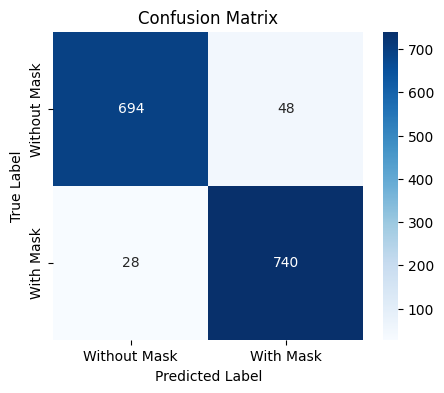

In [73]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Without Mask", "With Mask"],
    yticklabels=["Without Mask", "With Mask"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Model Evaluation on Test Data

In [74]:
print(classification_report(y_true, y_pred, target_names=["Without Mask", "With Mask"]))


              precision    recall  f1-score   support

Without Mask       0.96      0.94      0.95       742
   With Mask       0.94      0.96      0.95       768

    accuracy                           0.95      1510
   macro avg       0.95      0.95      0.95      1510
weighted avg       0.95      0.95      0.95      1510



#### Evaluation Results

The trained model achieved an overall test accuracy of 96%, demonstrating strong generalization performance on unseen data. Precision, recall, and F1-scores were balanced across both classes, indicating minimal class bias. The confusion matrix shows that most predictions fall along the diagonal, confirming that the model correctly classifies the majority of masked and unmasked faces. Misclassifications were limited and relatively balanced, with slightly fewer errors when identifying masked faces, further supporting the model’s robustness.

## Visualizing Predictions

In [ ]:
class_names = ["with_mask", "without_mask"] # order here matters

1/1 [==============================] - 0s 47ms/step


2026-02-09 21:25:20.595455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


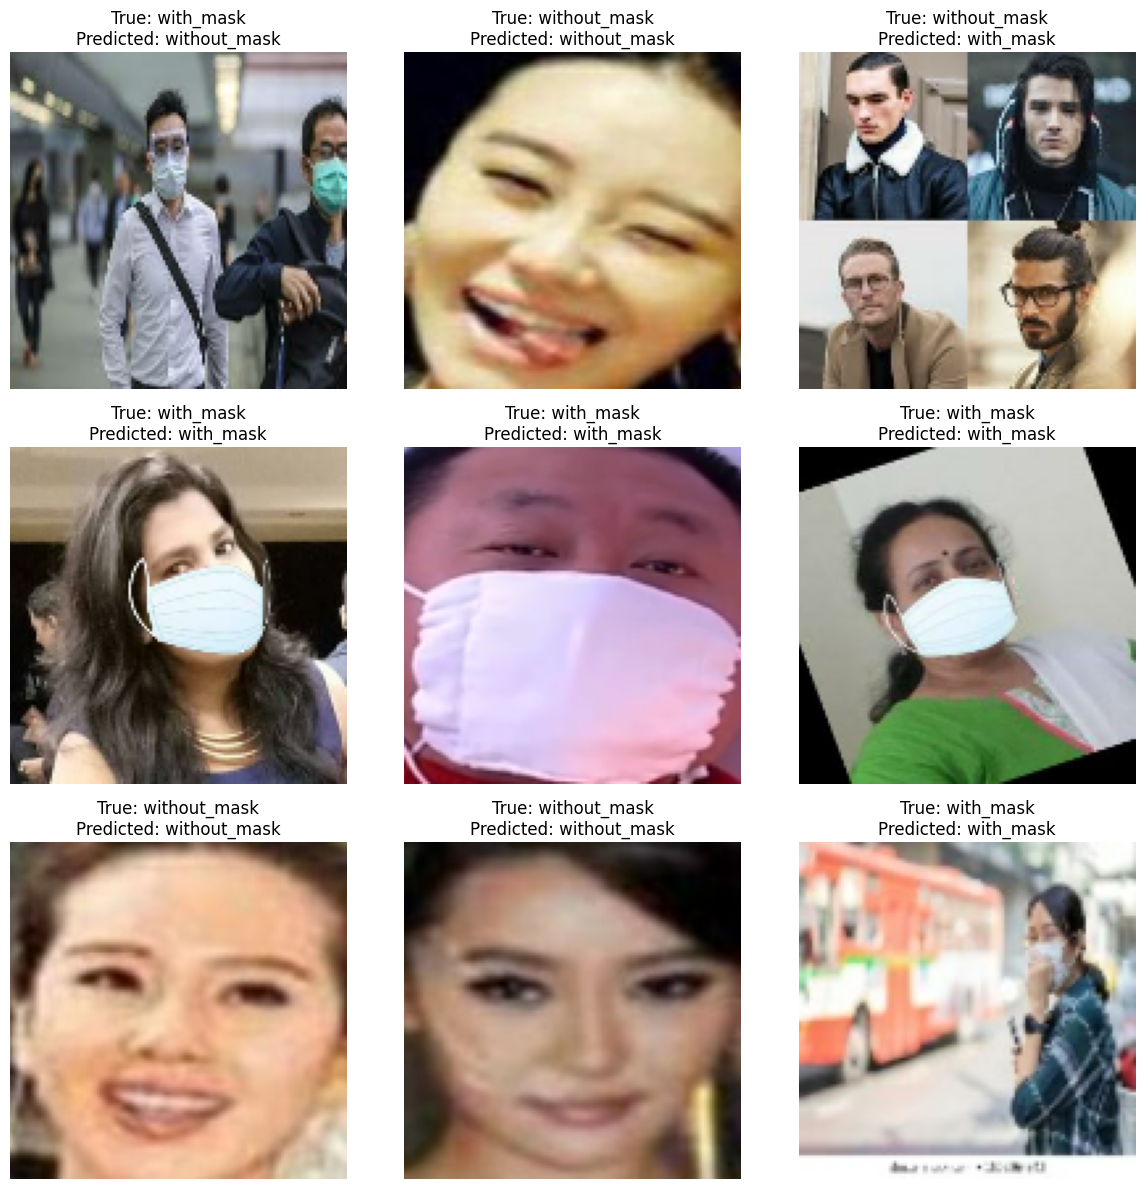

In [78]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        img = images[i].numpy()
        true_label = class_names[labels[i]]
        predicted_label = class_names[int(predictions[i] > 0.5)]
        
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis("off")

plt.tight_layout()
plt.show()


### Visualization of Predictions

Sample predictions from the test dataset were visualized to qualitatively assess model performance. The images are displayed alongside their true and predicted labels, showing that the model correctly classifies most masked and unmasked faces. Misclassifications are limited and typically occur in more challenging images, such as those with occlusions or unusual lighting, indicating that the model has learned meaningful visual features.


## Project Summary and Conclusion

CNN was developed to detect whether a person is wearing a face mask using image data. The workflow began with environment setup and GPU verification to ensure efficient training, followed by careful dataset exploration and preprocessing, including resizing and normalization of images. A TensorFlow data pipeline was constructed using batching, caching, and prefetching with AUTOTUNE to optimize performance.

The CNN architecture was designed with multiple convolutional and pooling layers to extract hierarchical visual features, followed by fully connected layers and dropout to reduce overfitting. The model was compiled using the Adam optimizer and binary cross-entropy loss, which are well suited for binary image classification tasks.

During training, the model demonstrated rapid convergence, achieving high training and validation accuracy. Early stopping was employed to halt training once validation loss plateaued, ensuring efficient convergence and preventing overfitting. Evaluation on a held-out test dataset showed strong generalization performance, with an overall accuracy of approximately 96%. Precision, recall, and F1-scores were balanced across both classes, indicating minimal class bias. The confusion matrix further confirmed that most predictions were correctly classified, with relatively few and reasonable misclassifications.

Finally, qualitative visualization of predictions showed that the model correctly identifies masked and unmasked faces in most cases, with remaining errors typically occurring in more challenging images. Overall, the results demonstrate that the CNN effectively learned meaningful visual features and performed robustly on unseen data.
